In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import bsr_matrix, coo_matrix
from scipy.sparse.linalg import eigsh
import joblib
from joblib import Parallel, delayed
import itertools
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
import contextlib
import copy
import seaborn as sns

import sys
import os
sys.path.insert(1, os.path.dirname(os.getcwd()))

In [2]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def construct_adjacency_matrix(X, n):
    k = X.shape[0]
    W = np.zeros((k, k))
    neigh = NearestNeighbors(n_neighbors=n+1).fit(X)
    neighbors = neigh.kneighbors(X, n_neighbors=n+1, return_distance=False)[:, 1:]
    for i in range(k):
        W[i, neighbors[i]] = 1
    W = coo_matrix(W)
    W = W + W.transpose()
    W = W.sign()
    return W

def train_and_evaluate(v, s, labels):
    E = v[:s]
    conf = []
    for label in np.unique(labels):
        Y = np.copy(labels)
        Y[labels == label] = 1
        Y[labels != label] = -1
        a = np.linalg.pinv(E) @ Y[:s]
        conf.append(np.sum(v[s:] * a, axis=1).tolist())
    conf = np.array(conf)
    pred_labels = np.argmax(conf, axis=0)
    return np.mean(pred_labels != labels[s:])

def train_and_evaluate_knn(X, s, labels):
    k_vals = [5]
    errors = []
    for k in k_vals:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X[:s], labels[:s])
        pred_labels = neigh.predict(X[s:])
        errors.append(np.mean(pred_labels != labels[s:]))
    return min(errors)

In [4]:
# load data
data = sio.loadmat("../datasets/TrainImages.mat")['TrainImages']
data = data/255.0
data = data.reshape(60000, 28*28)
X = PCA(n_components=100).fit_transform(data)

labels = sio.loadmat("../datasets/TrainImageLabels.mat")['Labels']
labels = np.array(labels, dtype='int').squeeze()
Y = np.copy(labels)

In [5]:
# set parameters
n = 8
p = 100
s_list = [20, 50, 100, 500, 1000, 5000, 20000, 50000]
num_reps = 20

In [6]:
# compute the adjancency matrices and the graph Laplacians
num_points_list = [1000, 10000, 60000]
v_list = []
for num_points in num_points_list:
    W = construct_adjacency_matrix(X[:num_points], n)
    d = np.array(np.sum(W, axis=1)).squeeze()
    D = coo_matrix(W.shape)
    D.setdiag(d)
    L = D - W

    # compute first p eigenvectors with smallest eigenvalues
    _ , v = eigsh(L, k=p, which='SM')
    v = np.real(v)
    v_list.append(v)

In [7]:
# train and evaluate
def loop(X, v_list, s, p, labels):
    p = min(s // 5, p) 
    error_lssl_1k = -1
    if s < 1000:
        v = v_list[0][:, :p]
        idx = np.random.permutation(1000)
        error_lssl_1k = train_and_evaluate(v[idx], s, labels[idx])

    error_lssl_10k = -1
    if s < 10000:
        v = v_list[1][:, :p]
        idx = np.random.permutation(10000)
        error_lssl_10k = train_and_evaluate(v[idx], s, labels[idx])

    v = v_list[2][:, :p]
    idx = np.random.permutation(len(v))
    error_lssl = train_and_evaluate(v[idx], s, labels[idx])
    error_knn = train_and_evaluate_knn(X, s, labels)

    return [error_lssl, error_lssl_1k, error_lssl_10k, error_knn]

mean_error_list = np.zeros((len(s_list), 4))
std_error_list = np.zeros((len(s_list), 4))
for i, s in enumerate(s_list):
    with tqdm_joblib(tqdm(desc="Run reps", total=num_reps)) as progress_bar:
        buffer = np.array(Parallel(n_jobs=-1)(delayed(loop)(X, v_list, s, p, labels) for r in range(num_reps)))
    mean_error_list[i] = np.mean(buffer, axis=0)
    std_error_list[i] = np.std(buffer, axis=0)

Run reps: 100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


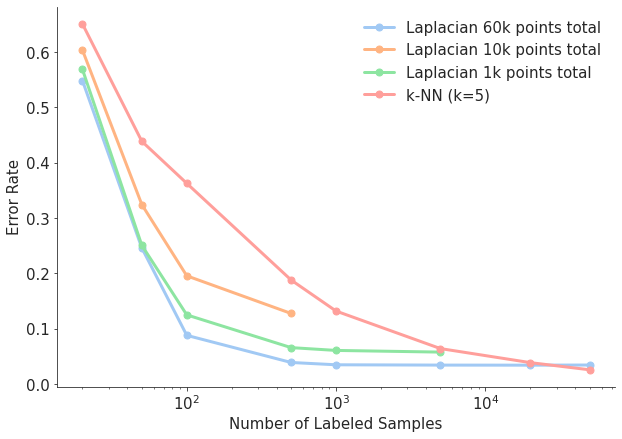

In [10]:
# plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")
s_list = np.array(s_list)
name_list = ["Laplacian 60k points total",
             "Laplacian 10k points total",
             "Laplacian 1k points total",
             "k-NN (k=5)"]
for i in range(mean_error_list.shape[-1]):
    errors = mean_error_list[:, i]
    idx = np.where(errors != -1)[0]
    ax.plot(s_list[idx], errors[idx], lw=3, marker='o', markersize=7, label=name_list[i])
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_xlabel("Number of Labeled Samples", fontsize=15)
ax.set_ylabel("Error Rate", fontsize=15)
ax.legend(fontsize=15, frameon=False)
sns.despine()
plt.show()

In [11]:
fig.savefig("figures/1-mnist.pdf", bbox_inches='tight')